# Data cleaning and pre-processing
### by Jonathan Fischer and Sasha Yousefi

In [1]:
# Load the necessary modules
from datascience import *
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats
plt.style.use('fivethirtyeight')
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
#from client.api.notebook import Notebook

## Normalization

### Raw data

In [2]:
# Load data using pd.read_csv('file_name', sep = ' ')
# matrix should be 5000 genes x 20 samples

raw_data = pd.read_csv('https://raw.githubusercontent.com/ds-connectors/Data88-Genetics_and_Genomics/master/Lab02/data_norm.csv', sep = ' ')

Let's say the first 10 columns are samples from healthy patients and the last ten from patients with an illness. We can assume that samples from the same condition should be similar to one another. To start, we can see whether they have similar numbers of total reads.

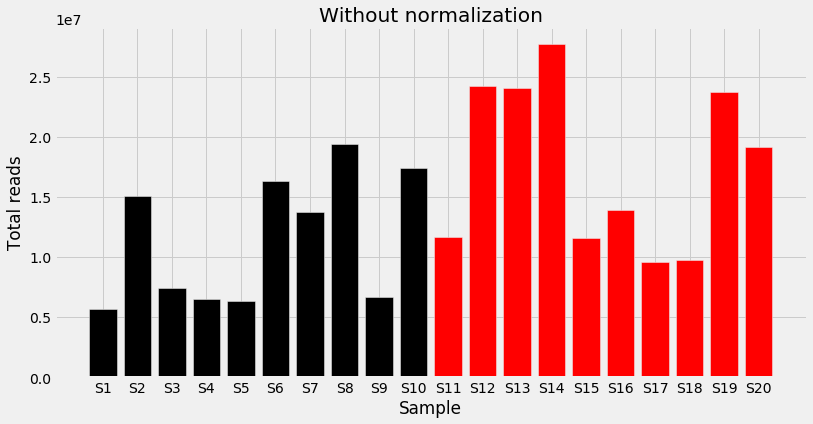

In [3]:
# First, take the sum of each column. np.sum(df) does this by default for a data frame df
total_counts = np.sum(raw_data)

# Make a barplot of the total number of reads in each sample for the healthy patients to investigate whether
# they have similar numbers of total reads.
# To the right of each line there is a #. Please fill in with what you think each line of the code does

bars = list(raw_data.columns)                    #
y_pos = np.arange(len(bars))                     #
col_list = ['Black']*10 + ['Red']*10             #

plt.figure(figsize=(12,6))                       #
plt.bar(y_pos, total_counts, color = col_list)   #
plt.xticks(y_pos, bars)                          #
plt.title('Without normalization')               #
plt.xlabel('Sample')                             #
plt.ylabel('Total reads')                        #
plt.show()                                       #

Let's see the effect of not normalizing on our ability to characterize differences in the gene expression profiles of healthy and sick patients. Since I created these, I can tell you that the overall median FC should be around 0.

In [4]:
# First, compute the mean of each gene within healthy and sick individuals
healthy_means_raw = np.mean(raw_data.iloc[:,0:10], axis = 1)
sick_means_raw = np.mean(raw_data.iloc[:,10:20], axis = 1)   # now repeat for the "sick" individuals in columns 11-20

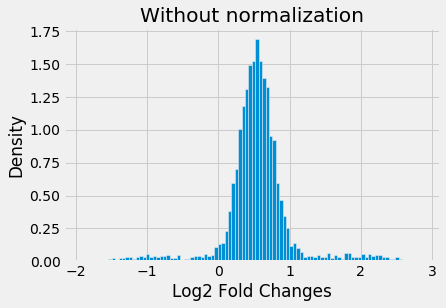

In [5]:
# Now that we have a single vector for each condition, make a histogram of the log2 fold changes between them
# Remember to add 1 before taking the log, e.g. np.log2(x+1)
# We'll eventually compare this to what we get after normalization

# sick minus healthy
raw_fc = np.log2(sick_means_raw+1) - np.log2(healthy_means_raw+1)
plt.hist(raw_fc,bins = 100, density = True)

plt.title('Without normalization') 
plt.xlabel('Log2 Fold Changes')
plt.ylabel('Density')
plt.show()

### Transcripts per Million

A common normalization is to divide by some scaling factor which is proportional to the total number of reads in a sample. This has fallen out of favor a bit, and we'll see why.

In [6]:
# Normalize the data using the Transcripts per Million (TPM) approach. 
# That is, divide each column by its sum and multiply by one million
# In this case, the division operator works column-wise on the df, so try df / total_counts * 1e6

TPM_data = raw_data / total_counts * 1e6

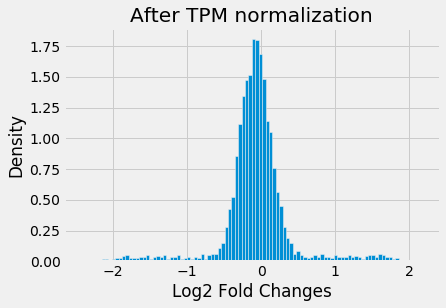

In [7]:
# Repeat the histogram by taking means and displaying the log2 FCs between conditions after TPM normalization
healthy_means_TPM = np.mean(TPM_data.iloc[:,0:10], axis = 1)
sick_means_TPM = np.mean(TPM_data.iloc[:,10:20], axis = 1)

# Now that we have a single vector for each condition, make a histogram of the log2 fold changes between them
# We'll eventually compare this to what we get after normalization
TPM_fc = np.log2(sick_means_TPM+1) - np.log2(healthy_means_TPM+1)

# make histogram
plt.hist(TPM_fc, bins = 100, density = True)

plt.title('After TPM normalization') 
plt.xlabel('Log2 Fold Changes')
plt.ylabel('Density')
plt.show()

### Median normalization

An alternative normalization is to use a scaling factor which is proportional to the median value in a sample. This avoids some of the pitfalls of TPM, though more sophisticated methods are usually better.

In [8]:
# Normalize the data my dividing each column by its median and then multiplying by 1000
# to get the column medians, try df.median()
medians = raw_data.median()
MN_data = raw_data / medians * 1e3

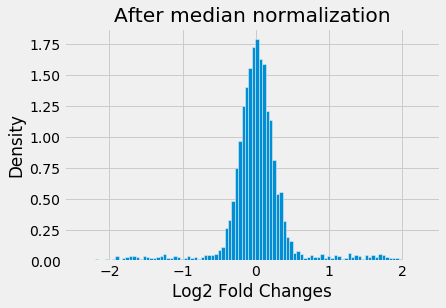

In [9]:
# Repeat the histogram by taking means and displaying the log2 FCs between conditions after median normalization
healthy_means_MN = np.mean(MN_data.iloc[:,0:10], axis = 1)
sick_means_MN = np.mean(MN_data.iloc[:,10:20], axis = 1)

# Now that we have a single vector for each condition, make a histogram of the log2 fold changes between them
# We'll eventually compare this to what we get after normalization
MN_fc = np.log2(sick_means_MN+1) - np.log2(healthy_means_MN+1)

# make histogram
plt.hist(MN_fc, bins = 100, density = True)

plt.title('After median normalization') 
plt.xlabel('Log2 Fold Changes')
plt.ylabel('Density')
plt.show()

## Outliers

In [10]:
# Load outlier data. Here we're initally assuming columns 1-10 are condition 1 and 11-25 are condition 2
outlier_table = pd.read_csv('https://raw.githubusercontent.com/ds-connectors/Data88-Genetics_and_Genomics/master/Lab02/data_outlier.csv', sep = ' ')

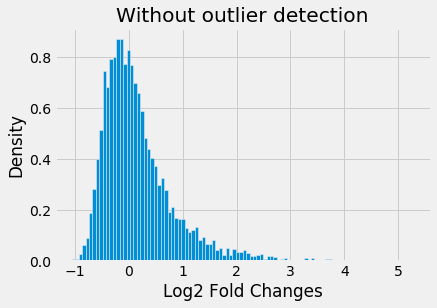

In [11]:
# Compute number of genes with log2 FC >= 1 b/w conditions and plot a histogram of the log2 FCs
cond1_means = np.mean(outlier_table.iloc[:,0:10], axis = 1)
cond2_means = np.mean(outlier_table.iloc[:,10:25], axis = 1)

outlier_fc = np.log2(cond2_means+1) - np.log2(cond1_means+1)

# We can sum booleans, or True/False values, to count how many are True. 
DE_1 = np.sum(outlier_fc >= 1)

# Make histogram
plt.hist(outlier_fc, bins = 100, density = True)

plt.title('Without outlier detection') 
plt.xlabel('Log2 Fold Changes')
plt.ylabel('Density')
plt.show()

In [12]:
# Run PCA and put the top PCs into a data frame
x = np.log2(outlier_table+1)
x = StandardScaler().fit_transform(x.transpose())
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

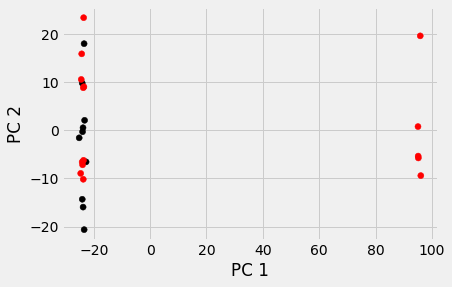

In [13]:
# Plot results of PCA and look for outliers
col_list = ['Black']*10 + ['Red']*15
plt.scatter(principalDf['PC1'], principalDf['PC2'], color = col_list)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

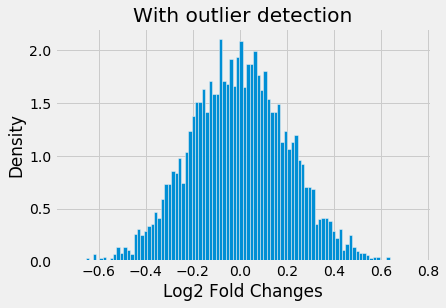

In [14]:
# Remove outliers. Now how many genes have abs log2 FC >= 1?
to_keep = principalDf['PC1'] < 0

to_keep.index = list(outlier_table.columns)
outlier_clean = outlier_table.loc[:,to_keep]

# Compute number of genes with log2 FC >= 1 b/w conditions and plot a histogram of the log2 FCs
cond1_means_corrected = np.mean(outlier_clean.iloc[:,0:10], axis = 1)
cond2_means_corrected = np.mean(outlier_clean.iloc[:,10:20], axis = 1)

outlier_corrected_fc = np.log2(cond2_means_corrected+1) - np.log2(cond1_means_corrected+1)
DE_2 = np.sum(outlier_corrected_fc >= 1)

# make histogram
plt.hist(outlier_corrected_fc, bins = 100, density = True)

plt.title('With outlier detection') 
plt.xlabel('Log2 Fold Changes')
plt.ylabel('Density')
plt.show()

## Confounders

In [15]:
# Load data and metadata for confounders
confounder_data = pd.read_csv('https://raw.githubusercontent.com/ds-connectors/Data88-Genetics_and_Genomics/master/Lab02/data_confounders.csv', sep = ' ', header = None)
confounder_meta = pd.read_csv('https://raw.githubusercontent.com/ds-connectors/Data88-Genetics_and_Genomics/master/Lab02/confounder_meta.csv', sep = ' ', header = None)

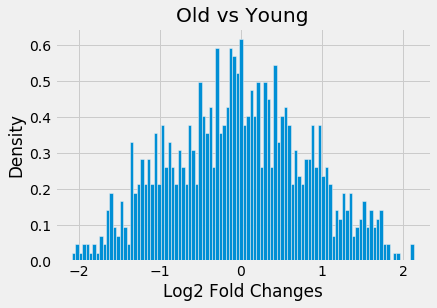

In [16]:
# Estimate FCs between age groups ('Old' and 'Young')
young_ind = confounder_meta.iloc[1,:] == 'Young'
old_ind = confounder_meta.iloc[1,:] == 'Old'

young_mean = np.mean(confounder_data.loc[:,young_ind], axis = 1)
old_mean = np.mean(confounder_data.loc[:,old_ind], axis = 1)

age_fcs = np.log2(old_mean+1) - np.log2(young_mean+1)

# make histogram
plt.hist(age_fcs, bins = 100, density = True)
plt.title('Old vs Young') 
plt.xlabel('Log2 Fold Changes')
plt.ylabel('Density')
plt.show()

In [17]:
# Compute FCs between age groups w/in each gender
ym_boolean = (confounder_meta.iloc[1,:] == 'Young') & (confounder_meta.iloc[0,:] == 'Male')
yf_boolean = (confounder_meta.iloc[1,:] == 'Young') & (confounder_meta.iloc[0,:] == 'Female')
om_boolean = (confounder_meta.iloc[1,:] == 'Old') & (confounder_meta.iloc[0,:] == 'Male')
of_boolean = (confounder_meta.iloc[1,:] == 'Old') & (confounder_meta.iloc[0,:] == 'Female')

ym_mean = np.mean(confounder_data.loc[:, ym_boolean], axis = 1)
yf_mean = np.mean(confounder_data.loc[:, yf_boolean], axis = 1)
om_mean = np.mean(confounder_data.loc[:, om_boolean], axis = 1)
of_mean = np.mean(confounder_data.loc[:, of_boolean], axis = 1)

# Old minus Young
male_age_fcs = np.log2(om_mean+1) - np.log2(ym_mean+1)
female_age_fcs = np.log2(of_mean+1) - np.log2(yf_mean+1)

In [18]:
# Construct a 2x2 table of the metadata frequencies 
# (young/old vs male/female)

n_ym = np.sum(ym_boolean)
n_yf = np.sum(yf_boolean)
n_om = np.sum(om_boolean)
n_of = np.sum(of_boolean)

# Recall syntax to make a table
#new_table = Table().with_columns([
#    '', ['Colname1', 'Colname2'],
#    'Rowname1', [val11, val12],
#    'Rowname2', [val21, val22],
#])

metadata_table = Table().with_columns([
    '', ['Young', 'Old'],
    'Male', [n_ym, n_om],
    'Female', [n_yf, n_of],
])

In [19]:
# Load true age-related FCs (age_fc.txt)
age_fc_true = np.log2(pd.read_csv('https://raw.githubusercontent.com/ds-connectors/Data88-Genetics_and_Genomics/master/Lab02/age_fc.csv', sep = ' ', header = None))

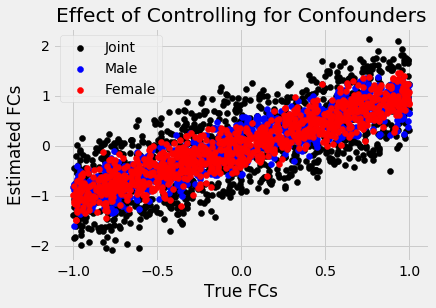

In [20]:
# Make plot of estiamted FCs for each cohort 
# (all, just men, just women) vs truth (put on same plot)

plt.scatter(age_fc_true, age_fcs, color = 'black')
plt.scatter(age_fc_true, male_age_fcs, color = 'blue')
plt.scatter(age_fc_true, female_age_fcs, color = 'red')

plt.title('Effect of Controlling for Confounders') 
plt.xlabel('True FCs')
plt.ylabel('Estimated FCs')
plt.legend(['Joint', 'Male', 'Female'])

plt.show()

# Putting it all together with real data

We'll now work with real RNA-seq samples primarily drawn from mammary tissue. However, there are also several samples which are actually blood and would negatively impact the analysis. Metadata is provided which tells whether a sample comes from a male/female and young/old donor. All data come from the GTEx consortium.

In [21]:
# Load raw data from GTEx. Will take a few seconds
GTEx_data = pd.read_csv('https://raw.githubusercontent.com/ds-connectors/Data88-Genetics_and_Genomics/master/Lab02/GTEX_raw_mammary_blood.csv', sep = ' ')

1) Compute the sum of total reads per sample. Remember to not include the index column when calculating (the last column). Then answer the question, will we need to normalize?

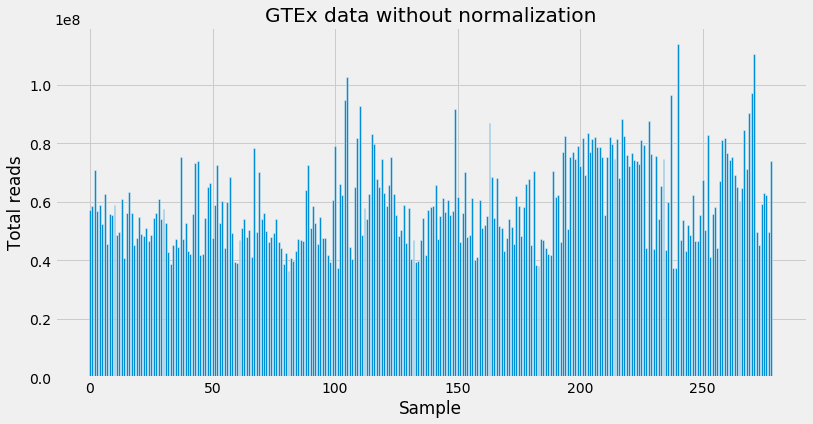

In [22]:
# Compute sum of reads
GTEx_TC = np.sum(GTEx_data)

# Make a barplot of the total number of reads
y_pos = np.arange(len(GTEx_TC))
plt.figure(figsize=(12,6))
plt.bar(y_pos, GTEx_TC)                                   # Fill in the missing places
plt.title('GTEx data without normalization') 
plt.xlabel('Sample')
plt.ylabel('Total reads')
plt.show()

2) Filter out lowly expressed genes (genes where the means across all patients is < 100 reads).

In [23]:
# Filter out lowly expressed genes (mean across samples <= 100)

GTEx_means = np.mean(GTEx_data, axis = 1)
sufficient_reads = GTEx_means > 100
GTEx_filtered = GTEx_data.loc[sufficient_reads,:]

3)  PCA to identify blood samples

In [24]:
# PCA to identify outliers

# Run PCA and put the top PCs into a data frame
x = np.log2(GTEx_filtered+1)
x = StandardScaler().fit_transform(x.transpose())
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

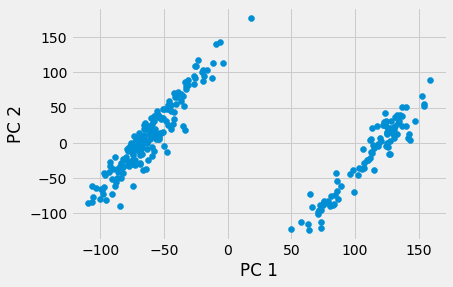

In [25]:
# Plot results of PCA and look for outliers
plt.scatter(principalDf['PC1'], principalDf['PC2'])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

4) Remove outliers

In [26]:
# Drop outliers. You'll want to retain the observations in the larger cluster on the left side of the plot
to_keep = principalDf['PC1'] < 40

to_keep.index = list(GTEx_filtered.columns)
GTEx_clean = GTEx_filtered.loc[:,to_keep]

5) Median normalization

In [27]:
# Normalize data using median approach

medians = GTEx_clean.median()
GTEx_MN = GTEx_clean / medians * 1e3

6) Load metadata

In [28]:
# Load metadata and label features
GTEx_meta = pd.read_csv('https://raw.githubusercontent.com/ds-connectors/Data88-Genetics_and_Genomics/master/Lab02/GTEX_mammary_meta.csv', sep = ' ', header = None)
GTEx_meta.index = ['Gender', 'Age']

GTEx_meta

,0,1,2,3,4,5,6,7,8,9,...,169,170,171,172,173,174,175,176,177,178
Gender,1,2,1,1,1,1,1,1,2,2,...,1,2,2,2,1,2,1,2,1,2
Age,62,64,64,55,43,62,58,62,21,66,...,59,59,56,62,31,38,30,45,24,50


7) PCA, color points by gender

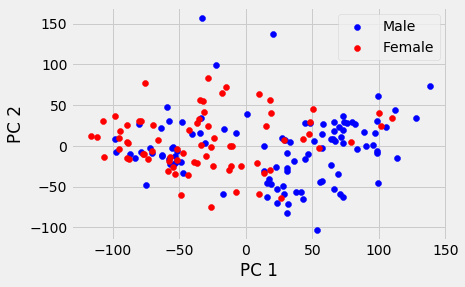

In [29]:
# Run PCA and plot
x = np.log2(GTEx_MN+1)
x = StandardScaler().fit_transform(x.transpose())
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

male_ind = (GTEx_meta.iloc[0,:] == 1)
female_ind = (GTEx_meta.iloc[0,:] == 2)

plt.scatter(principalDf['PC1'][male_ind], principalDf['PC2'][male_ind], color = 'Blue')
plt.scatter(principalDf['PC1'][female_ind], principalDf['PC2'][female_ind], color = 'Red')     # fill in missing entries
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(['Male', 'Female'])
plt.show()

8) Split np.log2(GTEx_MN+1) into tables for young and old women

In [30]:
x = np.log2(GTEx_MN+1)

yw_ind = (GTEx_meta.iloc[0,:] == 2) & (GTEx_meta.iloc[1,:] <= 50)
ow_ind = (GTEx_meta.iloc[0,:] == 2) & (GTEx_meta.iloc[1,:] > 50)

yw_ind.index = list(x.columns)
ow_ind.index = list(x.columns)

GTEx_yw = np.log2(GTEx_MN+1).loc[:,yw_ind]
GTEx_ow = np.log2(GTEx_MN+1).loc[:,ow_ind]

9) Compute FCs between old (>50) and young (<= 50) women and make a histogram

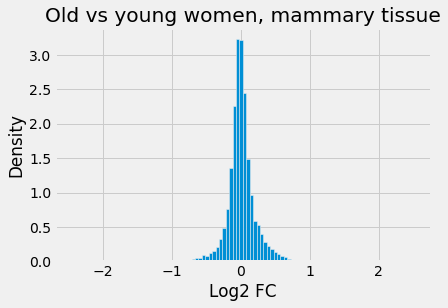

In [31]:
age_fc_women = np.mean(GTEx_ow, axis = 1) - np.mean(GTEx_yw, axis = 1)

# make a histogram
plt.hist(age_fc_women, bins = 100, density = True)
plt.xlabel('Log2 FC')
plt.ylabel('Density')
plt.title('Old vs young women, mammary tissue')
plt.show()

# To submit

In [32]:
#ok = Notebook('Lab02_Data_Cleaning.ok')
#_ = ok.auth(inline=True)

In [33]:
# Submit the assignment.
#_ = ok.submit()